In [1]:
!pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.9 MB/s eta 0:00:00


In [2]:
!pip3 install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 18.4 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376421 sha256=b75fe2b1657e601187a2d251ed0870ffe9b8f2abce36e899d6752851ae7facfe
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [8]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from torch.distributions import Normal
import numpy as np

In [4]:
#Hyperparameters
learning_rate = 0.0001
gamma         = 0.98
n_rollout     = 64

In [5]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim=24, action_dim=4, hidden_dim=256, learning_rate=0.0005):
        super(ActorCritic, self).__init__()
        self.data = []

        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc_pi = nn.Linear(hidden_dim, action_dim)
        self.fc_sigma = nn.Linear(hidden_dim, action_dim)
        self.fc_v = nn.Linear(hidden_dim, 1)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def pi(self, x):
        x = F.relu(self.fc1(x))
        mu = torch.tanh(self.fc_pi(x))
        sigma = F.softplus(self.fc_sigma(x)) + 0.1
        return mu, sigma

    def v(self, x):
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)
        return v

    def put_data(self, transition):
        self.data.append(transition)

    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, done_lst = [], [], [], [], []
        for transition in self.data:
            s, a, r, s_prime, done = transition
            s_lst.append(s)
            a_lst.append(a)
            r_lst.append([np.clip(r / 100.0, -1.0, 1.0)])
            s_prime_lst.append(s_prime)
            done_mask = 0.0 if done else 1.0
            done_lst.append([done_mask])

        s_batch = torch.tensor(s_lst, dtype=torch.float)
        a_batch = torch.tensor(a_lst, dtype=torch.float)
        r_batch = torch.tensor(r_lst, dtype=torch.float)
        s_prime_batch = torch.tensor(s_prime_lst, dtype=torch.float)
        done_batch = torch.tensor(done_lst, dtype=torch.float)
        self.data = []
        return s_batch, a_batch, r_batch, s_prime_batch, done_batch

    def train_net(self, gamma=0.99):
        s, a, r, s_prime, done = self.make_batch()
        td_target = r + gamma * self.v(s_prime) * done
        delta = td_target - self.v(s)

        mu, sigma = self.pi(s)
        dist = torch.distributions.Normal(mu, sigma)
        log_prob = dist.log_prob(a)
        entropy = dist.entropy().mean()

        loss_pi = -(log_prob * delta.detach()).mean()
        loss_v = F.smooth_l1_loss(self.v(s), td_target.detach())
        loss = loss_pi + loss_v - 0.02 * entropy

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


In [6]:
def main():
    env = gym.make('BipedalWalker-v3')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    model = ActorCritic(state_dim=state_dim, action_dim=action_dim)
    print_interval = 10
    avg_scores = []
    score = 0.0
    best_score = -float('inf')
    n_rollout = 20
    gamma = 0.99

    for n_epi in range(3000):
        done = False
        truncated = False
        s, _ = env.reset()
        episode_score = 0.0  # Current episode score

        while not (done or truncated):
            for t in range(n_rollout):
                s_tensor = torch.tensor(s, dtype=torch.float)
                mu, sigma = model.pi(s_tensor)
                dist = Normal(mu, sigma)
                a = dist.sample().numpy()
                a = torch.clamp(torch.tensor(a), -1.0, 1.0).numpy()  # Clamp actions to environment's action space

                s_prime, r, done, truncated, _ = env.step(a)
                model.put_data((s, a, r, s_prime, done))

                s = s_prime
                episode_score += r

                if (done or truncated):
                    break

            model.train_net(gamma=gamma)

        score += episode_score

        if episode_score > best_score:
            best_score = episode_score
            torch.save(model.state_dict(), f"actor_bipedal_{n_epi}.pth")
            print(f"New best score: {best_score}. Model saved.")

        if n_epi % print_interval == 0 and n_epi != 0:
            avg_score = score / print_interval
            avg_scores.append(avg_score)
            print(f"# of episode: {n_epi}, avg score: {avg_score:.1f}")
            score = 0.0

    env.close()
    plt.plot(avg_scores)
    plt.xlabel('Episodes (x20)')
    plt.ylabel('Average Score')
    plt.title('Average Score vs Episodes')
    plt.show()


<ipython-input-5-92c6689e08f2>:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  s_batch = torch.tensor(s_lst, dtype=torch.float)


New best score: -105.50471303701711. Model saved.
New best score: -100.08233144140647. Model saved.
# of episode: 10, avg score: -129.0
# of episode: 20, avg score: -129.2
# of episode: 30, avg score: -152.9
# of episode: 40, avg score: -137.1
# of episode: 50, avg score: -120.4
# of episode: 60, avg score: -132.3
# of episode: 70, avg score: -130.7
# of episode: 80, avg score: -144.0
# of episode: 90, avg score: -140.2
# of episode: 100, avg score: -134.8
# of episode: 110, avg score: -130.8
# of episode: 120, avg score: -126.1
# of episode: 130, avg score: -146.8
# of episode: 140, avg score: -117.3
# of episode: 150, avg score: -139.2
# of episode: 160, avg score: -121.8
# of episode: 170, avg score: -142.3
# of episode: 180, avg score: -127.6
# of episode: 190, avg score: -134.8
# of episode: 200, avg score: -121.1
# of episode: 210, avg score: -118.2
# of episode: 220, avg score: -156.8
# of episode: 230, avg score: -132.5
# of episode: 240, avg score: -117.3
# of episode: 250, av

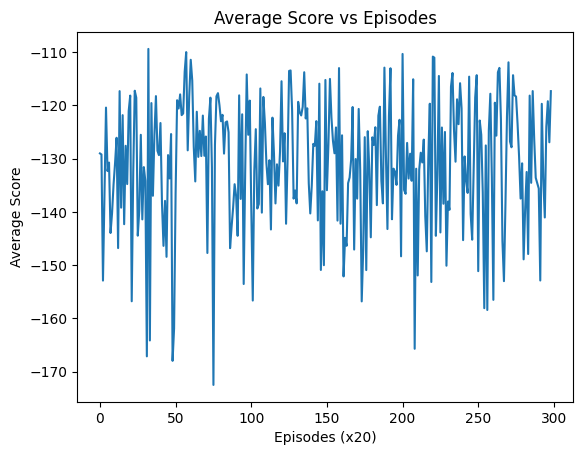

In [9]:
main()